<a href="https://colab.research.google.com/github/u-keigo/RRIproject1/blob/main/SVNS%E5%88%86%E9%A1%9E%E3%83%A2%E3%83%87%E3%83%AB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

クリーニング要る

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import pandas as pd


# DataFrameを読み込む（時間短縮）

# filename = '/content/drive/MyDrive/SVNS_df_108_70000.sav'
filename = '/content/drive/MyDrive/SVNS_df70000_detrend.sav'

with open(filename, 'rb') as web:
  DAT5 = pickle.load(web)   # DAT5 = DAT4

filename = '/content/drive/MyDrive/SVNS_df_108_70000.sav'

DAT5 = pd.DataFrame(DAT5[:,10,:])

with open(filename, 'rb') as web:
  DAT5.index = pickle.load(web).index   # DAT5 = DAT4

print(DAT5)
print(DAT5.isnull().sum(axis=1))
print(DAT5.index)

KeyError: ignored

In [ ]:
# DataFrameをドライブに保存(データの読み込みに時間がかかるのを防ぐ)

filename = 'SVNS_df70000_detrend.sav'
pickle.dump(DAT5, open(filename, 'wb'))

!cp "./{filename}" ./drive/My\ Drive/.

In [ ]:
import pickle
import pandas as pd

filename = '/content/drive/MyDrive/SVNS_df70000_detrend.sav'

with open(filename, 'rb') as web:
  DAT5 = pickle.load(web)   # DAT5 = DAT4

In [ ]:
# 列数をnum分割するようにデータフレームをreshapeする関数
# shape(108,10000) → shape(540,2000)

import pandas as pd
import numpy as np

def df_reshape(df, num):
  M = df.shape[0]   # 108
  N = df.shape[1]   # 10000
  
  df_new = pd.DataFrame(np.zeros(shape=(int(M*num), int(N/num))))

  count = 0
  for i in range(M):   # range(3) = 0,1,2
    for j in range(num):
      df_new = df_new.rename({count:df.index[i]},axis=0)   # indexの置換
      start = int(N/num)*j
      goal = int(N/num)*(j+1)   # 1:5 = 1,2,3,4
      df_new.iloc[count] = df.iloc[i, start:goal].to_numpy()   # 値だけ抽出するためにnumpy配列に変換
      count += 1
  
  return df_new

# データの長さを1/numし、データ数をnum倍する
DAT6 = df_reshape(DAT5, 28)

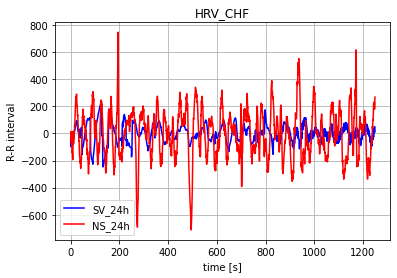

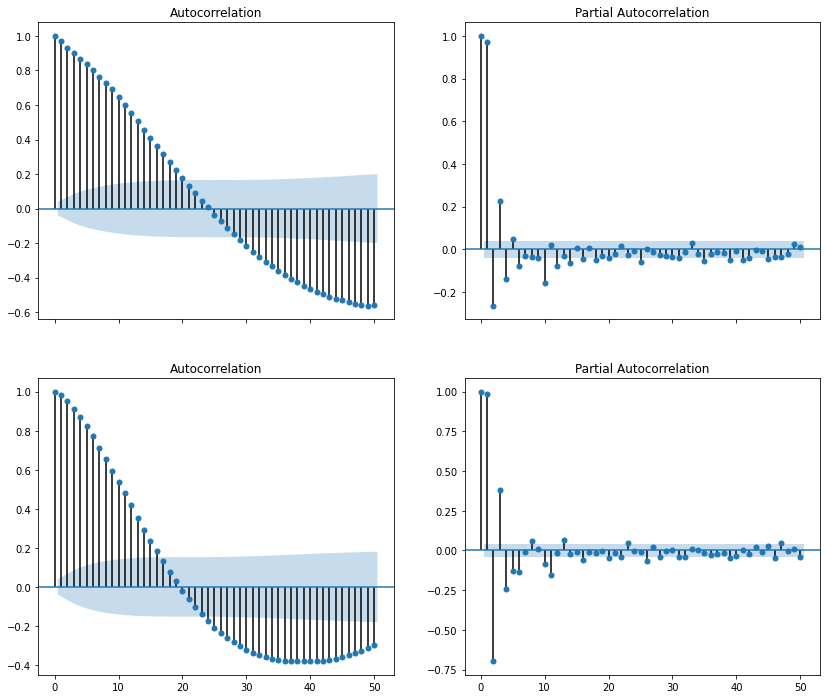

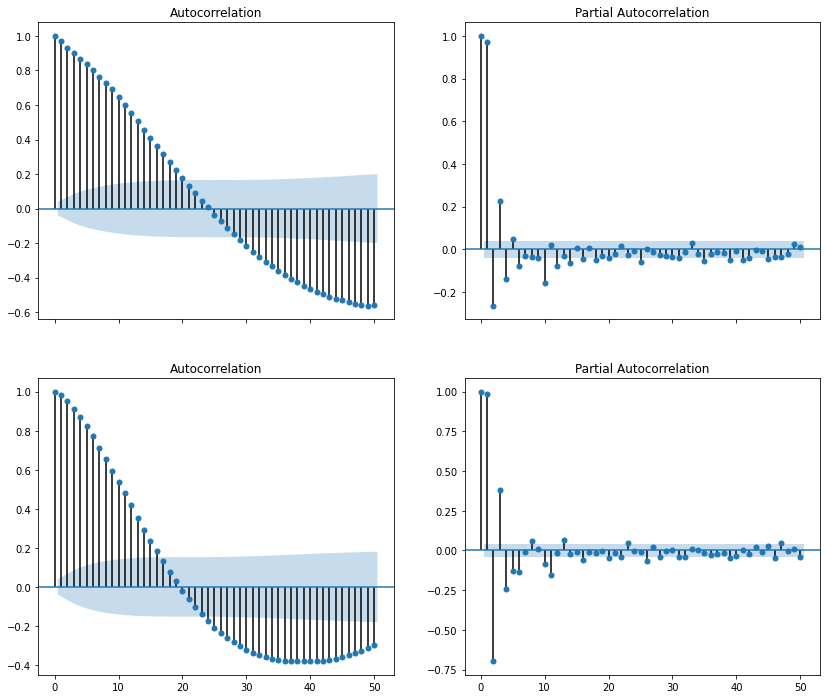

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

fix_length = DAT6.shape[1]   # データ点
dt = 0.5   # second
time_resamp = np.arange(0, fix_length*dt,dt)   # numpy型

SV_data = DAT6.loc[['SV_24h'],:]
NS_data = DAT6.loc[['NS_24h'],:]

plt.figure()
plt.plot(time_resamp, SV_data.iloc[0], color='blue', label=SV_data.index[0])
plt.plot(time_resamp, NS_data.iloc[0], color='red', label=NS_data.index[0])
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('R-R interval')
plt.title('HRV_CHF')
plt.grid()
plt.show()

# 自己相関を求める
# df_acf = sm.tsa.stattools.acf(SV_data.iloc[0], nlags=30)

fig, ([ax1, ax2],[ax3, ax4]) = plt.subplots(2, 2, sharex=True, figsize=(14,12))
sm.graphics.tsa.plot_acf(SV_data.iloc[0], lags=50, ax=ax1)
sm.graphics.tsa.plot_pacf(SV_data.iloc[0], lags=50, ax=ax2)
sm.graphics.tsa.plot_acf(NS_data.iloc[0], lags=50, ax=ax3)
sm.graphics.tsa.plot_pacf(NS_data.iloc[0], lags=50, ax=ax4)

In [ ]:
# カテゴリ変数を変換

df = DAT6
df['index'] = df.index
df.loc[:, 'index'] = df.loc[:, 'index'].map({'NS_24h':0, 'SV_24h':1})
DAT6.head()

df_reset = df.reset_index(drop=True) # インデックスを削除
df_reset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,index
0,-59.320584,-58.150635,-61.803184,-82.758571,-100.201943,-59.558746,-50.906211,-49.372543,-47.778256,-46.123348,-44.205289,-35.897497,-30.983807,-46.894639,-63.731813,-22.320782,-6.165586,-0.897515,1.302971,3.564077,5.781906,1.566849,1.035455,3.539040,6.103245,8.728070,11.413514,9.016722,10.912013,17.935162,13.273342,15.082398,18.131562,21.241345,24.411748,28.098468,38.174921,44.347696,47.760579,51.234081,...,-30.874240,-40.338183,-43.145477,-45.135574,-47.016682,-60.482547,-93.198718,-67.095736,-48.470356,-45.402680,-54.182451,-94.395008,-70.736013,-48.504659,-45.490523,-30.990018,-28.846670,-25.043802,-18.135953,-15.762745,-39.269260,-46.410475,-24.057988,12.385610,11.507275,-15.656752,-28.080355,-12.909673,23.448813,34.719504,8.496859,7.371888,40.474632,48.959193,50.984308,51.165269,39.808142,13.726483,12.801081,1
1,41.437329,64.154989,64.918537,65.543901,60.296492,58.286473,59.372594,59.324511,52.988725,46.252268,39.961503,34.012094,28.107579,21.710459,15.502363,-11.210173,-31.293687,0.251491,0.299071,0.019392,-0.735034,-5.902700,-10.943104,-15.687741,-40.184185,-47.248280,-18.482113,-21.028946,-19.285648,-15.588067,-11.760212,-8.185351,-10.867489,-9.404492,-5.063523,-0.736723,3.528240,-32.096194,-22.177740,5.430977,...,9.554994,-27.991392,3.067838,102.922022,146.015142,143.229046,140.466086,131.628806,83.884222,104.817396,117.300532,90.435636,58.123093,-0.972750,-135.411487,-173.443001,-172.502740,-140.041333,-130.652775,-137.424091,-160.508064,-182.221626,-140.313537,-10.392262,88.663289,85.567452,82.505165,75.716658,68.499515,68.183675,47.397173,23.207095,56.220671,63.090859,28.712316,2.949641,0.848364,-0.316393,-1.420088,1
2,-12.067869,-49.573463,-47.692821,-44.730495,-18.292417,8.322274,10.128626,11.941001,13.616493,9.667893,6.718179,-7.164218,-30.071789,8.829967,16.880934,11.651776,-12.521369,-39.354422,-35.362754,-7.062364,4.871395,1.776045,-5.103646,-15.782118,-44.906744,-24.430339,-18.724558,-18.589382,-17.513576,-28.202153,-69.850482,-50.637071,-35.964149,-55.858075,-80.209041,-56.991947,-60.718497,-61.595097,-87.999118,-100.015020,...,88.839504,140.452725,153.282122,124.634987,104.638024,102.373026,99.057361,89.397906,86.521613,84.446110,86.155151,89.669378,93.004658,127.285104,143.209699,149.655540,141.604055,85.370169,-6.568003,0.754442,14.256508,-10.589078,-3.796582,37.742094,44.322823,50.643216,20.246036,24.703764,35.906506,16.702757,46.963761,33.539757,13.104627,-18.671162,-38.236202,-33.267128,-36.963591,-3.864912,10.853348,1
3,7.746373,0.556521,-3.889122,4.556916,7.856813,4.361861,-2.264298,-18.371363,-45.311796,-10.773788,-33.183460,-21.574620,9.695041,10.026682,9.846439,-25.639529,-36.686948,-15.892536,4.521409,-19.341492,-43.931169,-82.736638,-94.153319,-70.925934,-39.234068,-41.467393,-44.088434,-43.713467,-43.145647,-51.033111,-74.834229,-101.499035,-68.050636,-89.687278,-107.408136,-104.902506,-104.481920,-111.327082,-111.781297,-116.705061,...,-48.201075,-77.332020,-94.088113,-89.560681,-79.699030,-39.681496,-19.829519,-11.537889,-30.273138,-86.375367,-61.990688,-53.406276,-44.300247,-29.831177,-20.541141,-41.543488,-45.130584,-27.917706,1.260663,20.293162,-48.802357,-18.372467,15.956117,17.350268,15.282398,12.602125,-24.479698,-16.913952,-1.581640,-30.050301,12.701700,26.897501,27.790945,27.959381,28.185084,28.485487,28.579137,26.145507,22.041157,1
4,7.874039,-51.579827,-53.556942,-24.541998,4.411852,10.364492,2.695250,0.335830,25.615116,86.328767,144.977702,108.606273,132.382881,112.310643,102.265183,118.419822,76.268304,100.277041,111.743304,105.124802,96.459578,90.374495,42.606945,52.705618,66.683317,45.175276,5.036884,-15.283452,-35.385203,-65.807796,-70.886894,-53.938399,-103.12187

In [ ]:
# Pytorchのデータセットに変換

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np


# Datasetクラスを作成
# 参考：https://dreamer-uma.com/pytorch-dataset/


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df, labels):
        self.features_values = df.drop(labels, axis=1).values
        self.labels = df[labels].values

    # len()を使用すると呼ばれる
    def __len__(self):
        return len(self.features_values)

    # 要素を参照すると呼ばれる関数    
    def __getitem__(self, idx):
        features_x = torch.FloatTensor(self.features_values[idx])
        labels = torch.LongTensor(self.labels[idx])
        
        return features_x, labels

# ラベルの名前
label = ['index']
Dataset = MyDataset(df_reset, label)
# print(Dataset[0])

In [ ]:
import torchvision.datasets as datasets

# 学習データ、テストデータに 7:3 の割合で分割する。
train_size = int(0.7 * len(Dataset))
test_size = len(Dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    Dataset, [train_size, test_size]
)

print(f"full: {len(Dataset)} -> train: {len(train_dataset)}, test: {len(test_dataset)}")


# train_datasetを学習データ、検証データに 9:1 の割合で分割する。
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

print(f"full: {len(Dataset)} -> train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}")

full: 3024 -> train: 2116, test: 908
full: 3024 -> train: 1904, val: 212, test: 908


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

# DataLoaderを使って、データセットを128個のミニパッチに分ける
# ミニパッチサイズを指定したデータローダを作成
train_batch = DataLoader(
    dataset = train_dataset,   # データセットの指定
    batch_size = batch_size,   # バッチサイズの指定
    shuffle = True,    # シャッフルするかどうかの指定
    num_workers = 2,   # コアの数
    drop_last = True) # データ数の異なるミニバッチを除去
# 参考：https://dreamer-uma.com/pytorch-dataloader/

val_batch = DataLoader(
    dataset = val_dataset,   # データセットの指定
    batch_size = batch_size,   # バッチサイズの指定
    shuffle = True,    # シャッフルするかどうかの指定
    num_workers = 2,
    drop_last = True)

test_batch = DataLoader(
    dataset = test_dataset,   # データセットの指定
    batch_size = batch_size,   # バッチサイズの指定
    shuffle = False,    # シャッフルするかどうかの指定
    num_workers = 2,
    drop_last = True)

In [ ]:
# 参考：https://qiita.com/THERE2/items/3c13164c1c82c1dcf4b7
# 参考：https://qiita.com/m__k/items/78a5125d719951ca98d3

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F

class LstmClassifier(nn.Module):
  def __init__(self, input_size, batch_size, hidden_size, output_size):
    super(LstmClassifier, self).__init__()
    self.batch_size = batch_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    # self.vocab_size = vocab_size
    # self.embed = nn.Embedding(vocab_size, embedding_length)
    # 学習済みの埋め込みベクトルを使用
    # self.embed.weight.data.copy_(weights)
    self.lstm = nn.LSTM(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers=1,  # default
                        dropout=0.2,
                        batch_first=True,
                        # bidirectional=True,
                        )
    self.dense = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    # x = self.embed(x)
    # 初期隠れ状態とセル状態を設定
    h0 = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
    # LSTMを伝搬する
    # output_seqの出力形状：（バッチサイズ、シーケンス長、出力次元）
    output_seq, (h_n, c_n) = self.lstm(x, (h0, c0))
    # 最後のタイムステップの隠れ状態をデコード
    out = self.dense(h_n[-1])
    # return out
    return torch.sigmoid(out) 

input_size = 1  # 入力次元
# batch_size = 32  # バッチサイズ
output_size = 2  # fcの出力次元
hidden_size = 128  # lstmの出力次元

net = LstmClassifier(input_size, batch_size, hidden_size, output_size)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = net.to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
# 損失関数、最適化関数を定義
criterion = nn.CrossEntropyLoss()
optim = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()))

In [ ]:
# 参考：https://zenn.dev/megane_otoko/articles/074_simple_pytorch

num_epochs = 200

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    # for i, batch in enumerate(train_batch):
    # for i in range(len(train_batch)):
    i = 0
    for data, labels in train_batch:
      data = data.unsqueeze(2)
      data = data.to(device)
      labels = labels.squeeze(1)
      labels = labels.to(device)
      optim.zero_grad()
      outputs = net(data)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optim.step()
    avg_train_loss = train_loss / len(train_batch.dataset)
    avg_train_acc = train_acc / len(train_batch.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
      for data, labels in val_batch:
        data = data.unsqueeze(2)
        data = data.to(device)
        labels = labels.squeeze(1)
        labels = labels.to(device)
        outputs = net(data)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(val_batch.dataset)
    avg_val_acc = val_acc / len(val_batch.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)
    i += 1

Epoch [1/200], Loss: 0.0101, val_loss: 0.0089, val_acc: 0.6274
Epoch [2/200], Loss: 0.0100, val_loss: 0.0089, val_acc: 0.6132
Epoch [3/200], Loss: 0.0100, val_loss: 0.0089, val_acc: 0.6226
Epoch [4/200], Loss: 0.0100, val_loss: 0.0089, val_acc: 0.6226
Epoch [5/200], Loss: 0.0099, val_loss: 0.0088, val_acc: 0.6368
Epoch [6/200], Loss: 0.0099, val_loss: 0.0089, val_acc: 0.6132
Epoch [7/200], Loss: 0.0099, val_loss: 0.0089, val_acc: 0.6085
Epoch [8/200], Loss: 0.0099, val_loss: 0.0088, val_acc: 0.6132
Epoch [9/200], Loss: 0.0098, val_loss: 0.0089, val_acc: 0.6038
Epoch [10/200], Loss: 0.0098, val_loss: 0.0088, val_acc: 0.6132
Epoch [11/200], Loss: 0.0097, val_loss: 0.0088, val_acc: 0.6132
Epoch [12/200], Loss: 0.0097, val_loss: 0.0089, val_acc: 0.6085
Epoch [13/200], Loss: 0.0097, val_loss: 0.0087, val_acc: 0.6179
Epoch [14/200], Loss: 0.0096, val_loss: 0.0089, val_acc: 0.5566
Epoch [15/200], Loss: 0.0095, val_loss: 0.0091, val_acc: 0.5519
Epoch [16/200], Loss: 0.0094, val_loss: 0.0087, v

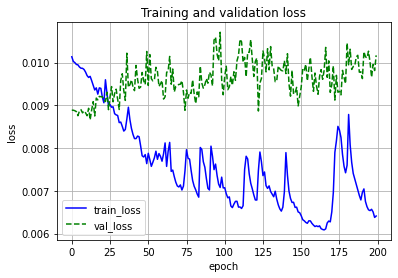

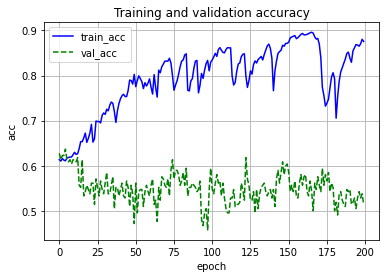

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

In [ ]:
net.eval()
with torch.no_grad():
  total = 0
  test_acc = 0
  for data, labels in test_batch:
    data = data.unsqueeze(2)
    data = data.to(device)
    labels = labels.squeeze(1)
    labels = labels.to(device)
    outputs = net(data)
    test_acc += (outputs.max(1)[1] == labels).sum().item()
    total += labels.size(0)
  print('精度： {} %'.format(100 * test_acc / total))

精度： 57.36607142857143 %


In [ ]:
# answer -> 正解ラベル、predict->LSTMの予測結果、exact->正解してたらO,間違っていたらX
predict_df = pd.DataFrame(columns=["answer", "predict", "exact"])

with torch.no_grad():
  for data, labels in test_batch:
    data = data.unsqueeze(2)
    data = data.to(device)
    labels = labels.squeeze(1)
    labels = labels.to(device)
    outputs = net(data)
    _, predict = torch.max(outputs, 1)
    exact = "O" if predict[1].item() == labels[1].item() else "X"
    s = pd.Series([labels[1].item(), predict[1].item(), exact], index=predict_df.columns)
    predict_df = predict_df.append(s, ignore_index=True)

print(predict_df)

   answer predict exact
0       0       1     X
1       0       1     X
2       1       0     X
3       0       0     O
4       1       1     O
5       1       1     O
6       0       1     X
7       1       1     O
8       0       0     O
9       0       1     X
10      1       0     X
11      1       0     X
12      1       1     O
13      0       1     X
